# IMU noise characterization using Allan deviation

Familiarity with the IEEE Standard 952 as well as with the nomenclature commonly used, the various units, etc, is helpful.

References

- mixture of gaussian:
https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of

Few notes:


In [1]:
%matplotlib inline
# plot the gyroscope historgram for few seconds of data
# https://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram
# https://stackoverflow.com/questions/70164620/how-to-gaussian-fit-histogram
# For gyro input in rad/s, the FWHM will be in rad/s
# TODO find relation between sigma and FWHM
import os # for file manipulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

In [10]:
HOME = os.getenv("HOME")
#CSV_FILENAME = 'imu_oakdpro_1hr_28032024.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR400_accSR500_yDown.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_level.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_xUp.csv'

# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_yDown.csv'
# CSV_FILENAME = 'oak_BNO086_30mn_gyrocalSR400_acclinSR500_level.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_yUp.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_zUp.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_zDown.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR400_accSR500.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR100_accSR125.csv' 
CSV_FILENAME = HOME+'/Data/Drones/IMU/oak_BNO086_60mn_gyroSR400_accSR500_xDown.csv'
FS = 400  # Sample rate [Hz] # this is obtained from the measured data
# ANGLE_UNIT_FOR_NOISE = 'rad' # or 'deg'
ANGLE_UNIT_FOR_NOISE =  'deg'
VELOCITY_UNIT_FOR_NOISE = 'm/s' # or e.g. 'cm/s'
ACCELERATION_UNIT_FOR_NOISE = 'm/s²' # or 'g'
PRECI= 2
TYPE = "e" # e: exponential notation
TS = 1.0 / FS
NB_SAMPLE = 1000 # nb of samples to take from the input data (csv file) for the historgram
DEG_2_RAD = np.pi / 180.0
RAD_2_DEG = 180.0 / np.pi
NBINS = 30 # number of bins for the histogram
LOAD_SAMPLE = 'all'
SAVE_FIG = True

The angular rate sensor is described by the quantities $N$ (angle random walk), $B$ (bias instability) and $K$ (rate random walk) from the IEEE Std 952. The values prescribed here approximate the properties of a Bosch SMI130 yaw rate sensor.

In [3]:
# functions
# for FHWM
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)
def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def fitfunc(x, a, b):
    return a*x + b


In [4]:
# Load CSV into np array (take few seconds so put in a separate cell)
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

In [5]:
# Separate into arrays and select a slice of the input data
if LOAD_SAMPLE == 'all':
    acc_ts = dataArr[:, 0]  # time stamp for acceleration, second
    accx = dataArr[:, 1]  # m/s²
    accy = dataArr[:, 2]
    accz = dataArr[:, 3]
    ts = dataArr[:, 4]  # time stamp, second
    gx = dataArr[:, 5]  # (rad/s)
    gy = dataArr[:, 6]
    gz = dataArr[:, 7]
elif LOAD_SAMPLE == 'start':
    acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
    accx = dataArr[:NB_SAMPLE, 1]  # m/s²
    accy = dataArr[:NB_SAMPLE, 2]
    accz = dataArr[:NB_SAMPLE, 3]
    ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
    gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
    gy = dataArr[:NB_SAMPLE, 6]
    gz = dataArr[:NB_SAMPLE, 7]
elif LOAD_SAMPLE == 'end':
    acc_ts = dataArr[-NB_SAMPLE:, 0]  # time stamp for acceleration, second
    accx = dataArr[-NB_SAMPLE:, 1]  # m/s²
    accy = dataArr[-NB_SAMPLE:, 2]
    accz = dataArr[-NB_SAMPLE:, 3]
    ts = dataArr[-NB_SAMPLE:, 4]  # time stamp, second
    gx = dataArr[-NB_SAMPLE:, 5]  # (rad/s)
    gy = dataArr[-NB_SAMPLE:, 6]
    gz = dataArr[-NB_SAMPLE:, 7]

In [6]:
if ANGLE_UNIT_FOR_NOISE == 'deg':
    gx = gx * (180.0 / np.pi)  # [deg/s]
    gy = gy * (180.0 / np.pi)
    gz = gz * (180.0 / np.pi)


In [7]:
# get some parameters about the data collection
dataArr_shape = dataArr.shape
tot_nb_sample = dataArr_shape[0]
print(f'total number of samples: {tot_nb_sample}')

total number of samples: 1440000


In [8]:
NB_DRIFT_OBSERVATION = 30
DRIFT_TIME = 60 # time over which to observe the drift, seconds

# Calculate gyro angles
def gyro_drifts(gyro_rate,drift_time = DRIFT_TIME, fsamp = FS, nb_drift_obervation =NB_DRIFT_OBSERVATION, verbose  = False):
    # drift_time time over which to observe the drift, seconds
    nb_sample = int(drift_time * fsamp)
    tsamp = 1/fsamp # smpling period
    t_drift = np.arange(0,drift_time,tsamp)
    if verbose:
        print(t_drift,len(t_drift))
        print(nb_sample)
    thetax = np.zeros((nb_drift_obervation,nb_sample))
    for i in range(nb_drift_obervation):
        thetax[i] = np.cumsum(gyro_rate[20000*i:20000*i+nb_sample]) * tsamp # 
    return t_drift,thetax

def gyro_drifts_all_axis(gyro_rate_x,gyro_rate_y,gyro_rate_z,drift_time = DRIFT_TIME, fsamp = FS, nb_drift_obervation =NB_DRIFT_OBSERVATION, verbose  = False):
    # drift_time time over which to observe the drift, seconds
    nb_sample = int(drift_time * fsamp)
    tsamp = 1/fsamp # smpling period
    t_drift = np.arange(0,drift_time,tsamp)
    if verbose:
        print(t_drift,len(t_drift))
        print(nb_sample)
    thetaxyz = np.zeros((nb_drift_obervation,nb_sample))
    for i in range(nb_drift_obervation):
        grx = np.cumsum(gyro_rate_x[20000*i:20000*i+nb_sample])
        gry = np.cumsum(gyro_rate_y[20000*i:20000*i+nb_sample])
        grz = np.cumsum(gyro_rate_z[20000*i:20000*i+nb_sample])
        thetaxyz[i] = np.sqrt(grx*grx + gry*gry + grz*grz) * tsamp # 
    return t_drift,thetaxyz

In [9]:
# Calculate gyro angles
DRIFT_TIME = 60 # time over which to observe the drift, seconds
NB_SAMPLE = DRIFT_TIME * FS
t_drift = np.arange(0,60,TS)
print(t_drift,len(t_drift))
print(NB_SAMPLE)
NB_DRIFT_OBSERVATION = 30
thetax = np.zeros((NB_DRIFT_OBSERVATION,NB_SAMPLE))
for i in range(NB_DRIFT_OBSERVATION):
    thetax[i] = np.cumsum(gx[10000*i:10000*i+NB_SAMPLE]) * TS  # 
    # thetax[i] = np.cumsum(gx[i*i:i*i+NB_SAMPLE]) * TS  # deg or rad depending on ANGLE_UNIT_FOR_NOISE
# thetay = np.cumsum(gy) * TS
# thetaz = np.cumsum(gz) * TS
print(thetax[0])


[0.00000e+00 2.50000e-03 5.00000e-03 ... 5.99925e+01 5.99950e+01
 5.99975e+01] 24000
24000
[-1.52592985e-03 -2.74661643e-03 -3.20440971e-03 ...  2.13685168e+00
  2.13563100e+00  2.13517320e+00]


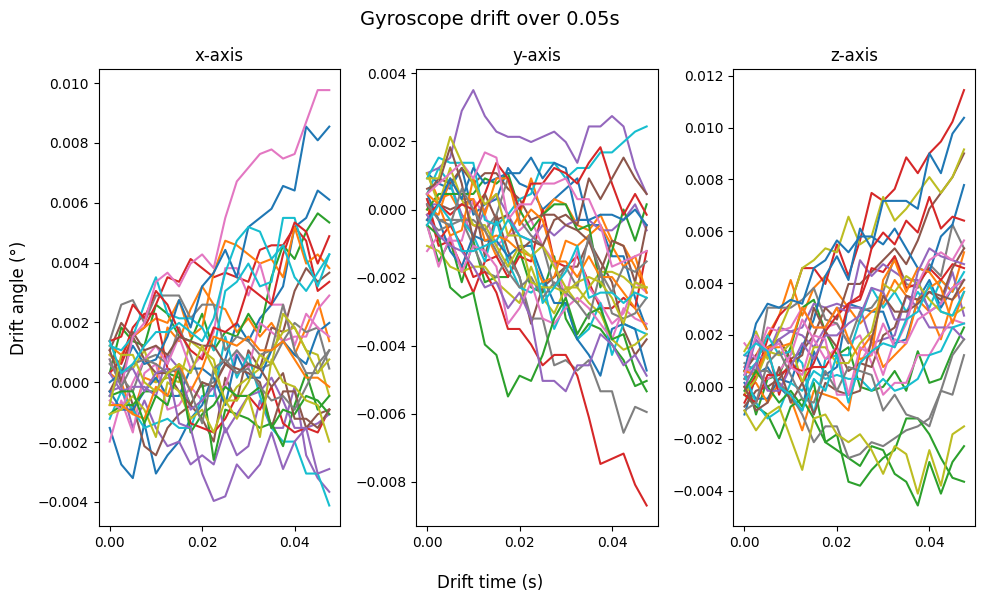

In [15]:
drift_time = 1/20 #0.1
nb_drift_observation=NB_DRIFT_OBSERVATION
figyro,axgyro = plt.subplots(1,3,figsize=(10,6), tight_layout=True)
figyro.suptitle(f"Gyroscope drift over {drift_time}s", fontsize=14)
figyro.supxlabel('Drift time (s)')
figyro.supylabel('Drift angle (°)')

t_drift, drift_gx = gyro_drifts(gx,drift_time)
t_drift, drift_gy = gyro_drifts(gy,drift_time)
t_drift, drift_gz = gyro_drifts(gz,drift_time)
# figyro.text(-0.01, 0.95, 'test', transform=figyro.transFigure, horizontalalignment='center')

for i in range(nb_drift_observation):
    axgyro[0].plot(t_drift,drift_gx[i])
    axgyro[0].set_title('x-axis')
    # axgyro[0].legend(["gx"])
    # axgyro[0].set_ylabel('Drift angle (°)')
    axgyro[1].plot(t_drift,drift_gy[i])
    axgyro[1].set_title('y-axis')
    axgyro[2].plot(t_drift,drift_gz[i])
    axgyro[2].set_title('z-axis')



In [17]:
if SAVE_FIG:
    figyro.savefig(f'gyro_drift_xyz.png')    

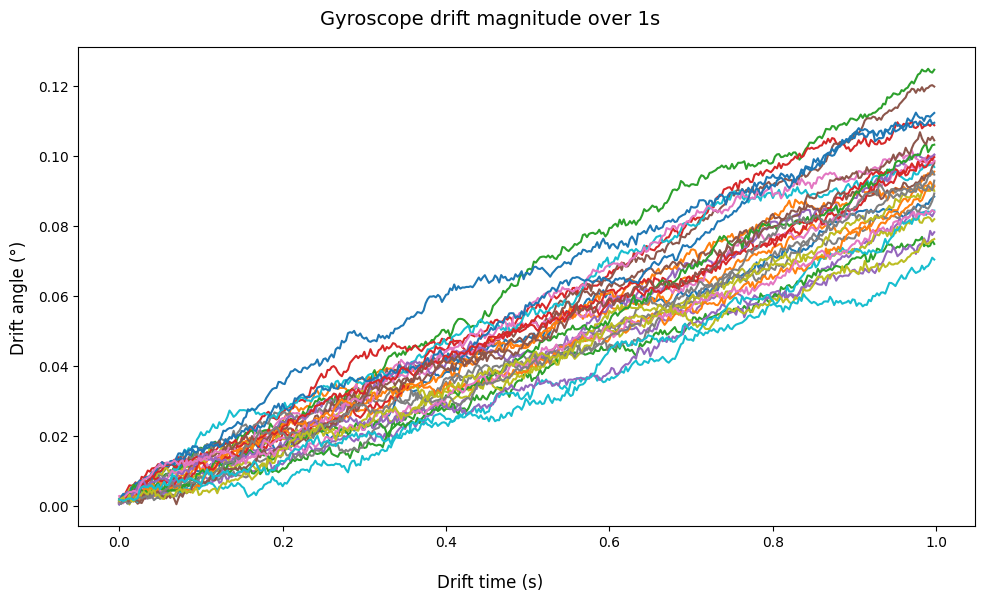

In [20]:
drift_time = 1 #0.1

figyro,axgyro = plt.subplots(1,figsize=(10,6), tight_layout=True)
figyro.suptitle(f"Gyroscope drift magnitude over {drift_time}s", fontsize=14)
figyro.supxlabel('Drift time (s)')
figyro.supylabel('Drift angle (°)')

t_drift, drift_gxyz = gyro_drifts_all_axis(gx,gy,gz,drift_time)

for i in range(NB_DRIFT_OBSERVATION):
    axgyro.plot(t_drift,drift_gxyz[i])

In [21]:
if SAVE_FIG:
    figyro.savefig(f'gyro_drift_magnitude.png')    

## Accelerometer

In [105]:
print(len(ts))
ts_s = TS
velx = np.cumsum(accx[:1000])*ts_s
distx = np.cumsum(velx)*ts_s

vely = np.cumsum(accy[:1000])*ts_s
disty = np.cumsum(vely)*ts_s

print(TS)

1440000
0.0025


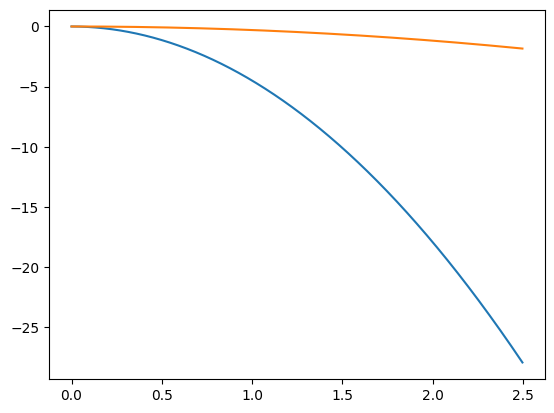

In [106]:
t_distx = np.arange(0,1000*TS,TS)
fig,ax = plt.subplots(1)
ax.plot(t_distx,distx)
ax.plot(t_distx,disty)

In [107]:
# n: number of measurements
# dt: sampling rate [s], e.g. dt = 1e-2 when sampling at 100 Hz
def generate_signal(n, dt, noise_density, random_walk, random_state=0):
    rng = np.random.RandomState(random_state)
    white = noise_density / np.sqrt(dt) * rng.randn(n)
    walk = random_walk * np.sqrt(dt) * np.cumsum(rng.randn(n))
    return white + walk

In [108]:
a=generate_signal(1000,1e-2,0.01,0.001)

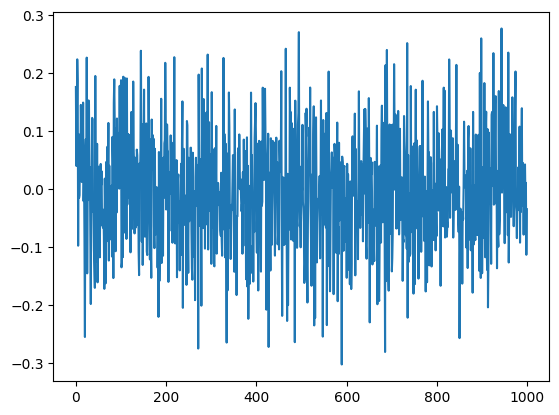

In [109]:
plt.plot(a)

## Old

[0.00000e+00 2.50000e-03 5.00000e-03 ... 5.99925e+01 5.99950e+01
 5.99975e+01] 24000
24000


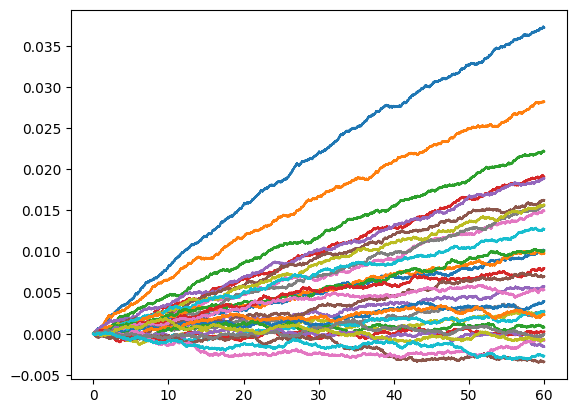

In [10]:
t_drift, drift_gx = gyro_drifts(gx)
plt.figure()
for i in range(NB_DRIFT_OBSERVATION):
    plt.plot(t_drift,drift_gx[i])